# Transforming adversarial network

In [ ]:
# XXX: extend by seeding labels in some realizations of U

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = plt.set_cmap("viridis")
import numpy as np
np.random.seed(777)

In [2]:
# Require https://github.com/diana-hep/carl

from carl.distributions import MultivariateNormal
from carl.distributions import Mixture

# p_U
prior_p_U = [0.6, 0.4]
c0 = MultivariateNormal(mu=np.array([-2, -2.]), sigma=0.5*np.eye(2))
c1 = MultivariateNormal(mu=np.array([2, 2.]), sigma=np.eye(2))
p_U = Mixture(components=[c0, c1], weights=prior_p_U)
U = p_U.rvs(10000)

# p_X
prior_p_X = [0.6, 0.4] 
c0 = MultivariateNormal(mu=np.array([-2, -2.]), sigma=0.5*np.eye(2))
c1 = MultivariateNormal(mu=np.array([2, -2.]), sigma=np.eye(2))
p_X = Mixture(components=[c0, c1], weights=prior_p_X)

X_0 = c0.rvs(int(prior_p_X[0] * len(U)))
X_1 = c1.rvs(int(prior_p_X[1] * len(U)))
X = np.vstack((X_0, X_1))
y = np.zeros(len(X))
y[len(X_0):] = 1

In [3]:
import keras.backend as K
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import Regularizer

class LossHistory(Callback):
    def __init__(self):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Using Theano backend.


In [4]:
D = Sequential()
D.add(Dense(12, input_dim=U.shape[1]))
D.add(LeakyReLU())
D.add(Dense(12))
D.add(LeakyReLU())
D.add(Dense(12))
D.add(LeakyReLU())
D.add(Dense(12))
D.add(LeakyReLU())
D.add(Dense(1, activation='sigmoid'))

def loss_D(y_true, y_pred):
    return -((1.0 - y_true) * (K.log(1.0 - y_pred)) + 
             (y_true) * (K.log(y_pred)))  

In [5]:
class MappingRegularizer(Regularizer):
    def __init__(self, G, l1=0., l2=0.):
        self.G = G
        self.l1 = l1
        self.l2 = l2

    def set_layer(self, layer):
        self.layer = layer

    def __call__(self, loss):
        x = self.G.get_input(True)
        Gx = self.layer.get_output(True)
        loss += self.l1 * K.mean(K.abs(x[:, :X.shape[1]] - Gx))
        loss += self.l2 * K.mean(K.square(x[:, :X.shape[1]] - Gx))
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__,
                "l1": self.l1,
                "l2": self.l2}

G = Sequential()
G.add(Dense(12, input_dim=X.shape[1] + 1))
G.add(LeakyReLU())
G.add(Dense(12))
G.add(LeakyReLU())
G.add(Dense(12))
G.add(LeakyReLU())
G.add(Dense(12))
G.add(LeakyReLU())
G.add(Dense(U.shape[1], activation='linear',
            activity_regularizer=MappingRegularizer(G, l2=0.0001, l1=0.0)))
G.compile(loss="mse", optimizer="sgd")  

GD = Sequential()
GD.add(G)
D.trainable = False
GD.add(D)

def loss_GD(y_true, y_pred):
    return y_true * (K.log(y_pred))

In [6]:
C = Sequential()
C.add(Dense(12, input_dim=U.shape[1]))
C.add(LeakyReLU())
C.add(Dense(12))
C.add(LeakyReLU())
C.add(Dense(12))
C.add(LeakyReLU())
C.add(Dense(12))
C.add(LeakyReLU())
C.add(Dense(1, input_dim=12, activation='sigmoid'))

GC = Sequential()
GC.add(G)
C.trainable = False
GC.add(C)

def loss_GC(y_true, y_pred):
    return -((1.0 - y_true) * (K.log(1.0 - y_pred)) + 
             (y_true) * (K.log(y_pred)))  

In [7]:
D.compile(loss=loss_D, optimizer="sgd")
C.compile(loss=loss_GC, optimizer="sgd")
GD.compile(loss=loss_GD, optimizer="sgd")
GC.compile(loss=loss_GC, optimizer="sgd")

In [8]:
# Pretrain D
_X = np.vstack((U, G.predict(np.hstack((X, y.reshape(-1, 1))))))
_y = np.zeros(len(_X))
_y[len(U):] = 1
D.fit(_X, _y, nb_epoch=50, verbose=0)

In [9]:
# Pretrain C
_X = np.vstack((G.predict(np.hstack((X_0, np.zeros((len(X_0), 1))))), 
                G.predict(np.hstack((X_1, np.ones((len(X_1), 1)))))))
_y = np.zeros(len(_X))
_y[len(X_0):] = 1
C.fit(_X, _y, nb_epoch=50, verbose=0)

In [10]:
def plot_distribution(D, G, X, y, U):
    bounds = [[-5,5], [-5,5]]
    
    plt.hist2d(X[:, 0], X[:, 1], bins=30, range=bounds, normed=1)
    plt.title("x~p_X")
    plt.show()
    
    plt.hist2d(U[:, 0], U[:, 1], bins=30, range=bounds, normed=1)
    plt.title("u~p_U")
    plt.show()

    GX = G.predict(np.hstack((X, y.reshape(-1, 1))))
    plt.hist2d(GX[:, 0], GX[:, 1], bins=30, range=bounds, normed=1)
    plt.title("G(x, y), x,y~p_X,Y")
    plt.show()
    
def plot_transform(G, label):
    plt.title("G(x, y=%d)" % label)
    _X, _Y = np.meshgrid(np.linspace(-5, 5, num=15), np.linspace(-5, 5, num=15))   
    Z = G.predict(np.hstack((_X.ravel().reshape(-1, 1), 
                             _Y.ravel().reshape(-1, 1),
                             label * np.ones((_X.ravel().shape[0], 1)))))
    GX = Z[:, 0].reshape(_X.shape) - _X
    GY = Z[:, 1].reshape(_Y.shape) - _Y
    plt.quiver(_X, _Y, GX, GY,  scale_units='xy', angles='xy', scale=1, alpha=0.3)
    plt.show()

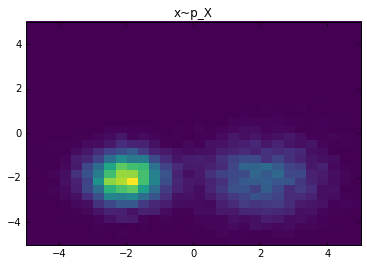

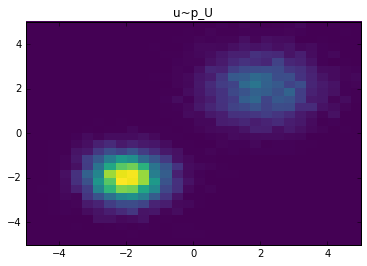

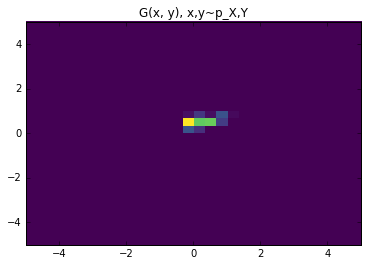

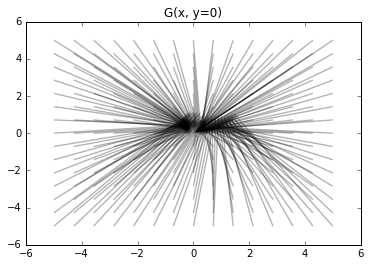

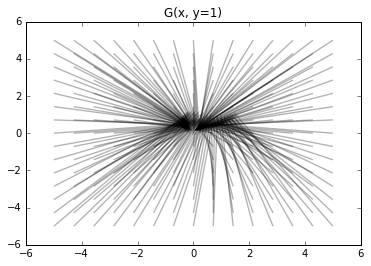

In [11]:
plot_distribution(D, G, X, y, U)
plot_transform(G, label=0.)
plot_transform(G, label=1.)

In [12]:
def batches_D(batch_size, X, y, U):
    _y = np.zeros(batch_size)
    _y[batch_size // 2:] = 1 
    
    while True:
        indices_u = np.random.permutation(len(U))[:batch_size // 2]
        indices_x = np.random.permutation(len(X))[:batch_size - len(indices_u)]
        _X = np.vstack((U[indices_u],
                        G.predict(np.hstack((X[indices_x],
                                             y[indices_x].reshape(-1, 1))))))
        
        yield _X, _y
        
        
def batches_C(batch_size, X, y):
    while True:
        indices = np.random.permutation(len(X))[:batch_size]
        yield G.predict(np.hstack((X[indices],
                                   y[indices].reshape(-1, 1)))), y[indices]
        
        
def batches_GD(batch_size, X, y):
    _y = np.ones(batch_size)
    
    while True:
        indices = np.random.permutation(len(X))[:batch_size]
        yield np.hstack((X[indices], y[indices].reshape(-1, 1))), _y
       
    
def batches_GC(batch_size, X, y):
    while True:
        indices = np.random.permutation(len(X))[:batch_size]
        yield np.hstack((X[indices], y[indices].reshape(-1, 1))), y[indices]

In [13]:
logs_D = LossHistory()
logs_C = LossHistory()
logs_GD = LossHistory()
logs_GC = LossHistory()

In [14]:
batch_size = 32
gen_D = batches_D(batch_size, X, y, U)
gen_C = batches_C(batch_size, X, y)
gen_GD = batches_GD(batch_size, X, y)
gen_GC = batches_GC(batch_size, X, y)

for i in range(10000):
    if i % 250 == 0: print(i)
    
    for j in range(3): # train D and C more than G for stability
        D.fit(*next(gen_D), nb_epoch=1, verbose=0, callbacks=[logs_D])
        C.fit(*next(gen_C), nb_epoch=1, verbose=0, callbacks=[logs_C])  
        
    GD.fit(*next(gen_GD), nb_epoch=1, verbose=0, callbacks=[logs_GD])
    GC.fit(*next(gen_GC), nb_epoch=1, verbose=0, callbacks=[logs_GC])

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750


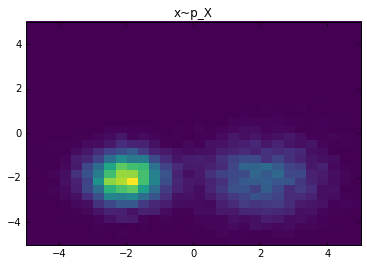

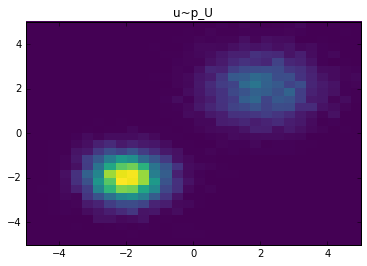

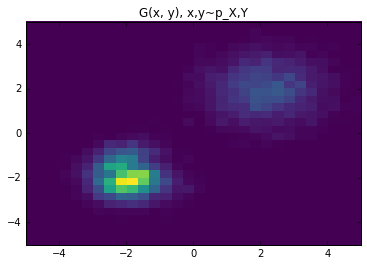

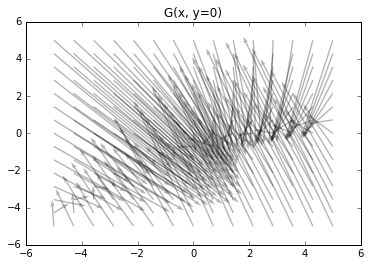

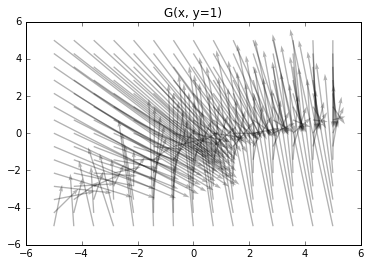

In [15]:
plot_distribution(D, G, X, y, U)
plot_transform(G, label=0.)
plot_transform(G, label=1.)

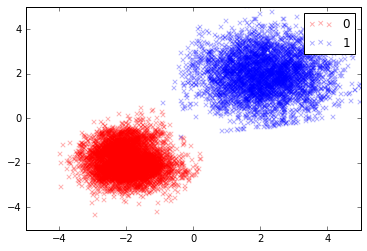

In [16]:
G0 = G.predict(np.hstack((X_0, np.zeros((len(X_0), 1)))))
G1 = G.predict(np.hstack((X_1, np.ones((len(X_1), 1)))))
plt.scatter(G0[:, 0], G0[:, 1], marker="x", color="r", label="0", alpha=0.3)
plt.scatter(G1[:, 0], G1[:, 1], marker="x", color="b", label="1", alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.show()

[]

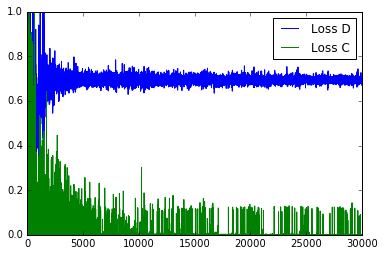

In [17]:
# XXX: Should evaluate on validation instead!
plt.plot(list(range(len(logs_D.losses))), np.array(logs_D.losses), label="Loss D")
plt.plot(list(range(len(logs_C.losses))), np.array(logs_C.losses), label="Loss C")
plt.legend()
plt.ylim(0, 1)
plt.plot()